In [35]:
import numpy as np
import pandas as pd
import GPy
import time
import sys
import os
import pdb
import matplotlib.pyplot as plt

from context import aep
from context import load_data
from context import delete_blocks
from context import start_df
from context import save_df
from context import metrics
from thesis_work.plots import GP_figures
from thesis_work.plots import SGP_figures
from thesis_work.plots import DGP_figures

from baseline_models import full_GP_reg
from baseline_models import sparse_GP_reg
from aep_config import cont_optimization
from aep_config import aep_DGP_reg

default_dict = {'M': 50, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':100,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': []}
os.getcwd()
%matplotlib

Using matplotlib backend: nbAgg


# Load data: normalise, delete blocks

Dataset size:  100  Test size:  40.0
Training:  125
Dataset size:  100  Test size:  40.0
Training:  75
Removing blocks... [-2, 0.5, 1, 1.05, 1.6, 2.1]
Removing blocks... [0.5, 1, 1.1, 1.7]


<IPython.core.display.Javascript object>


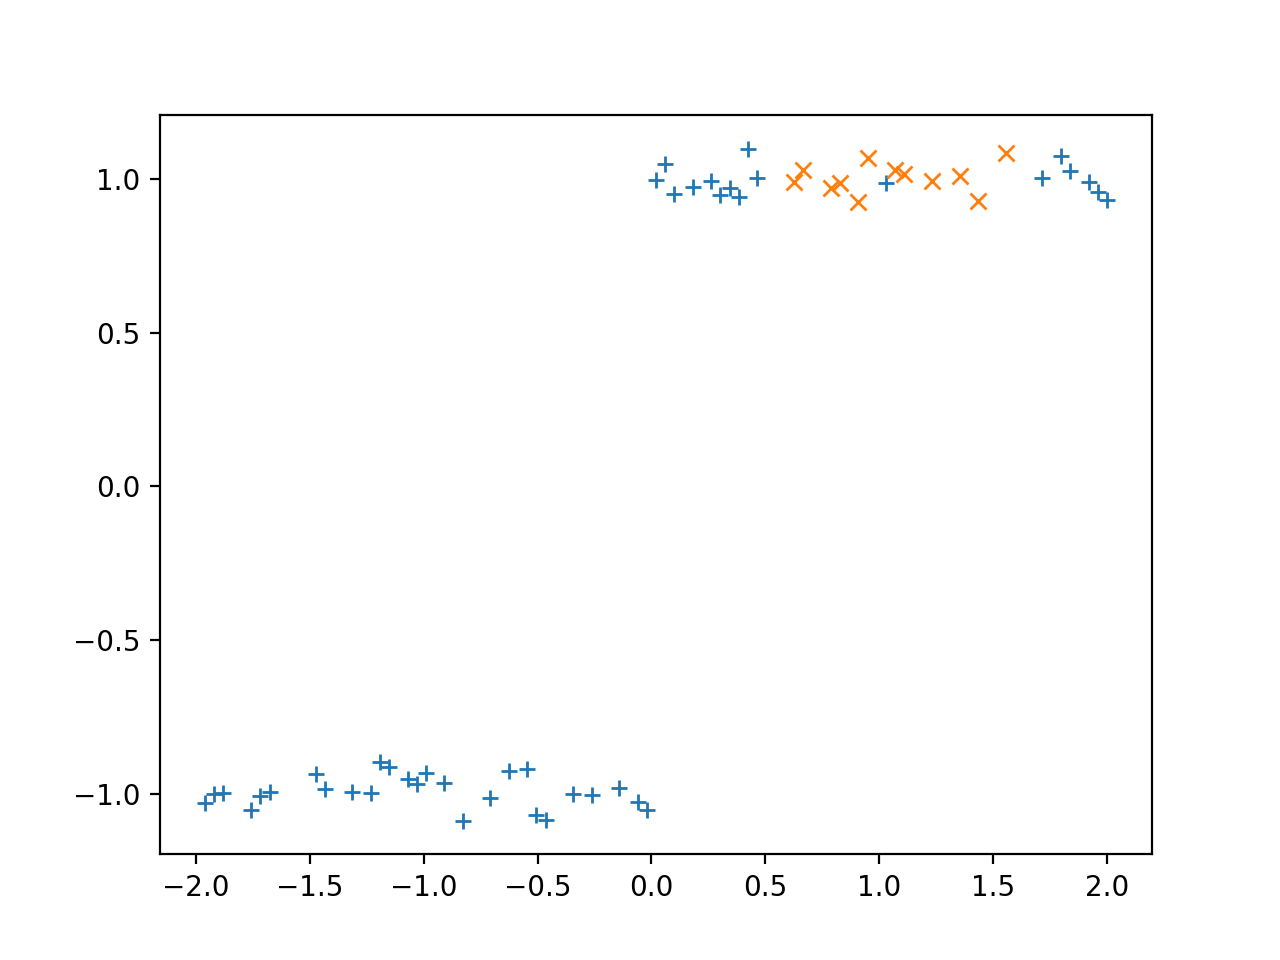

(44, 1) (12, 1)


In [139]:
path = 'data/step_short.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=125, test=0.0, norm_out=False)

X_train, y_train, X_test, y_test = load_data(path, N_train=75, test=0.4, norm_out=False)
X_test, y_test = delete_blocks(X_test, y_test,
                               intervals=[-2,0.5,1,1.05,1.6,2.1])
X_train, y_train = delete_blocks(X_train, y_train,
                               intervals=[0.5,1,1.1,1.7])
# [-1.50,-1.3,-1.2,-0.5,0.5,1,1.1,1.7]
plt.figure()
plt.plot(X_train, y_train, '+')
plt.plot(X_test, y_test, 'x')
plt.show()
print X_train.shape, X_test.shape

## Sparse GP

create full GP model and optimize ...
Test MSE =0.040, NLL =0.304


<IPython.core.display.Javascript object>


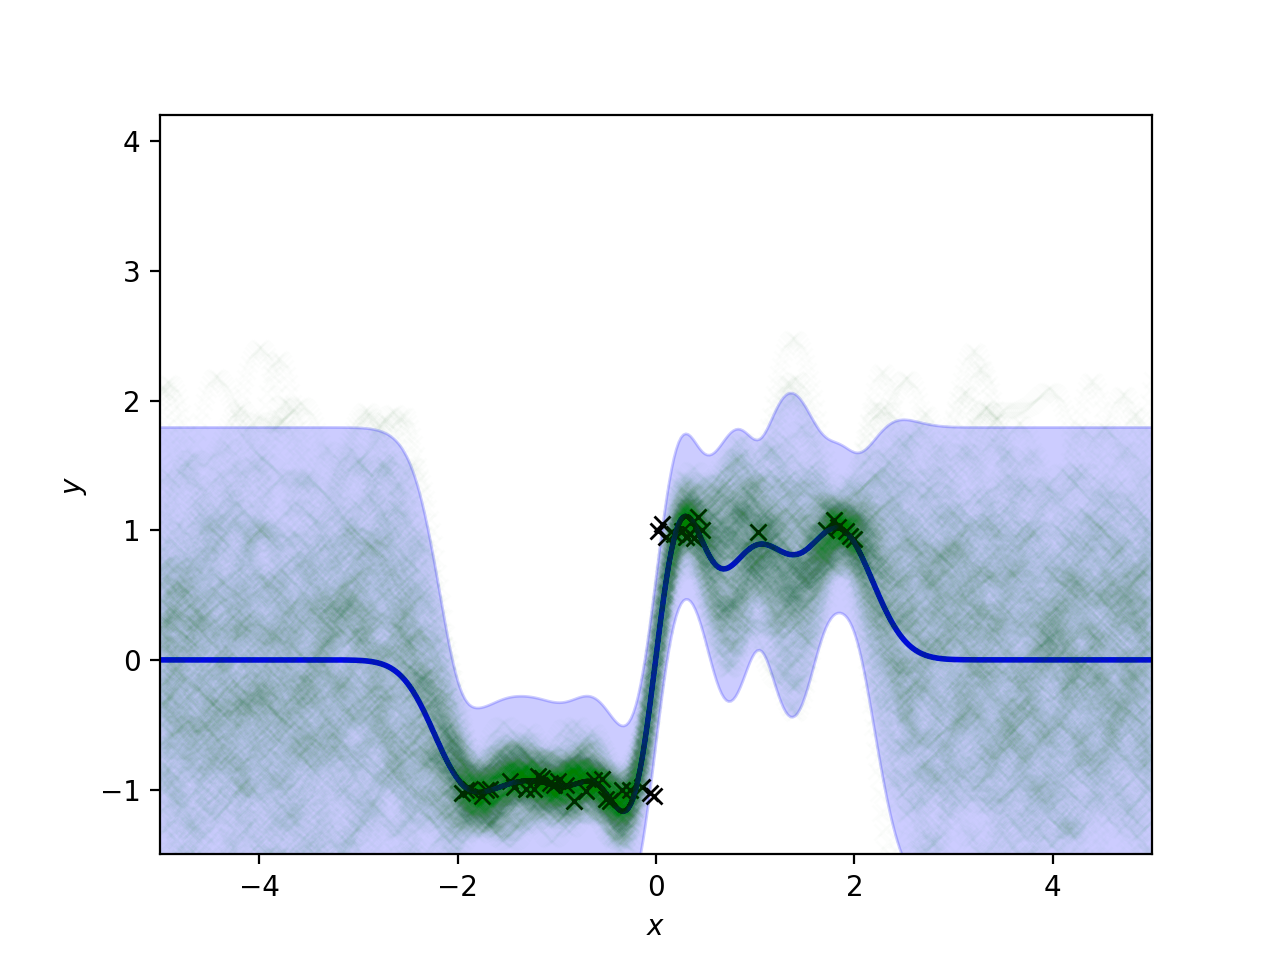

In [140]:
model_gp, df = full_GP_reg(X_train, y_train, X_test, y_test)

fig = GP_figures(model_gp).plot()
plt.xlim([-5,5])
testX = np.linspace(-5, 5, 500).reshape(-1, 1)
posteriorTestY = model_gp.posterior_samples_f(testX, full_cov=True, size=100)
plt.plot(testX, posteriorTestY, "xg", alpha=0.01)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.ylim([-1.5,4.2])
# plt.ylim([-2.5,2.5])
plt.show()


create SGP model and optimize ...
Test MSE =0.048, NLL =0.964


<IPython.core.display.Javascript object>


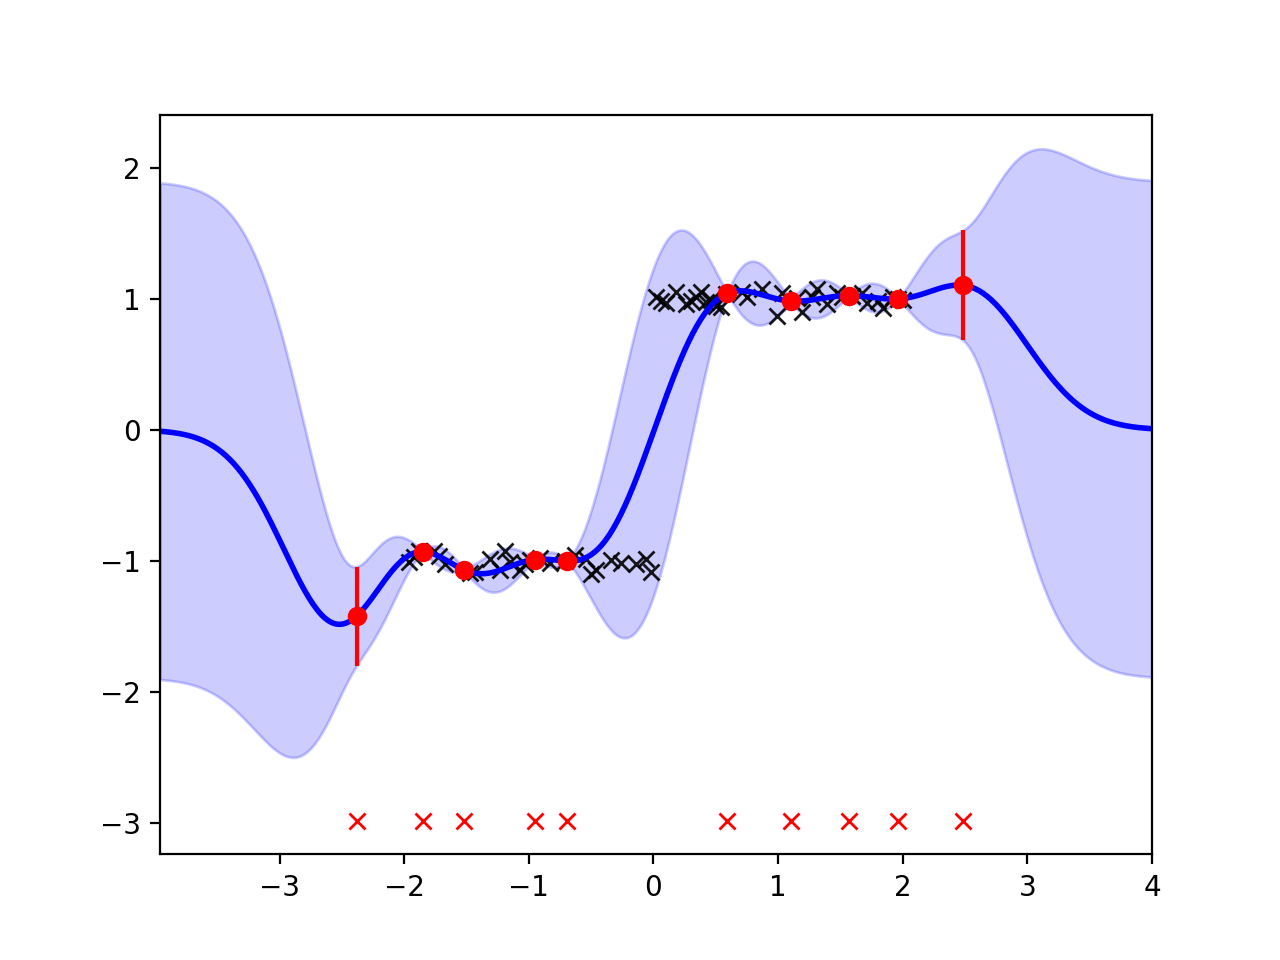

In [39]:
model_sgp, df = sparse_GP_reg(X_train, y_train, X_test, y_test, M=10)
fig = SGP_figures(model_sgp).plot()

# AEP Deep GPs

Create DGP model and optimize ...
Optimise with fixed:  []
Default initialisation
iter 0 	 obj 48.007
iter 50 	 obj 4.474
iter 100 	 obj 3.286
iter 150 	 obj 2.477
iter 200 	 obj 1.856
iter 250 	 obj 1.429
iter 300 	 obj 1.174
iter 350 	 obj 1.046
iter 400 	 obj 0.983
iter 450 	 obj 0.949
iter 500 	 obj 0.925
iter 550 	 obj 0.905
iter 600 	 obj 0.887
iter 650 	 obj 0.872
iter 700 	 obj 0.858
iter 750 	 obj 0.846
iter 800 	 obj 0.835
iter 850 	 obj 0.826
iter 900 	 obj 0.818
iter 950 	 obj 0.810
iter 1000 	 obj 0.804
iter 1050 	 obj 0.797
iter 1100 	 obj 0.791
iter 1150 	 obj 0.786
iter 1200 	 obj 0.780
iter 1250 	 obj 0.775
iter 1300 	 obj 0.771
iter 1350 	 obj 0.766
iter 1400 	 obj 0.762
iter 1450 	 obj 0.757
Test MSE= 0.066, NLL= 0.209, SN= 0.236


<IPython.core.display.Javascript object>


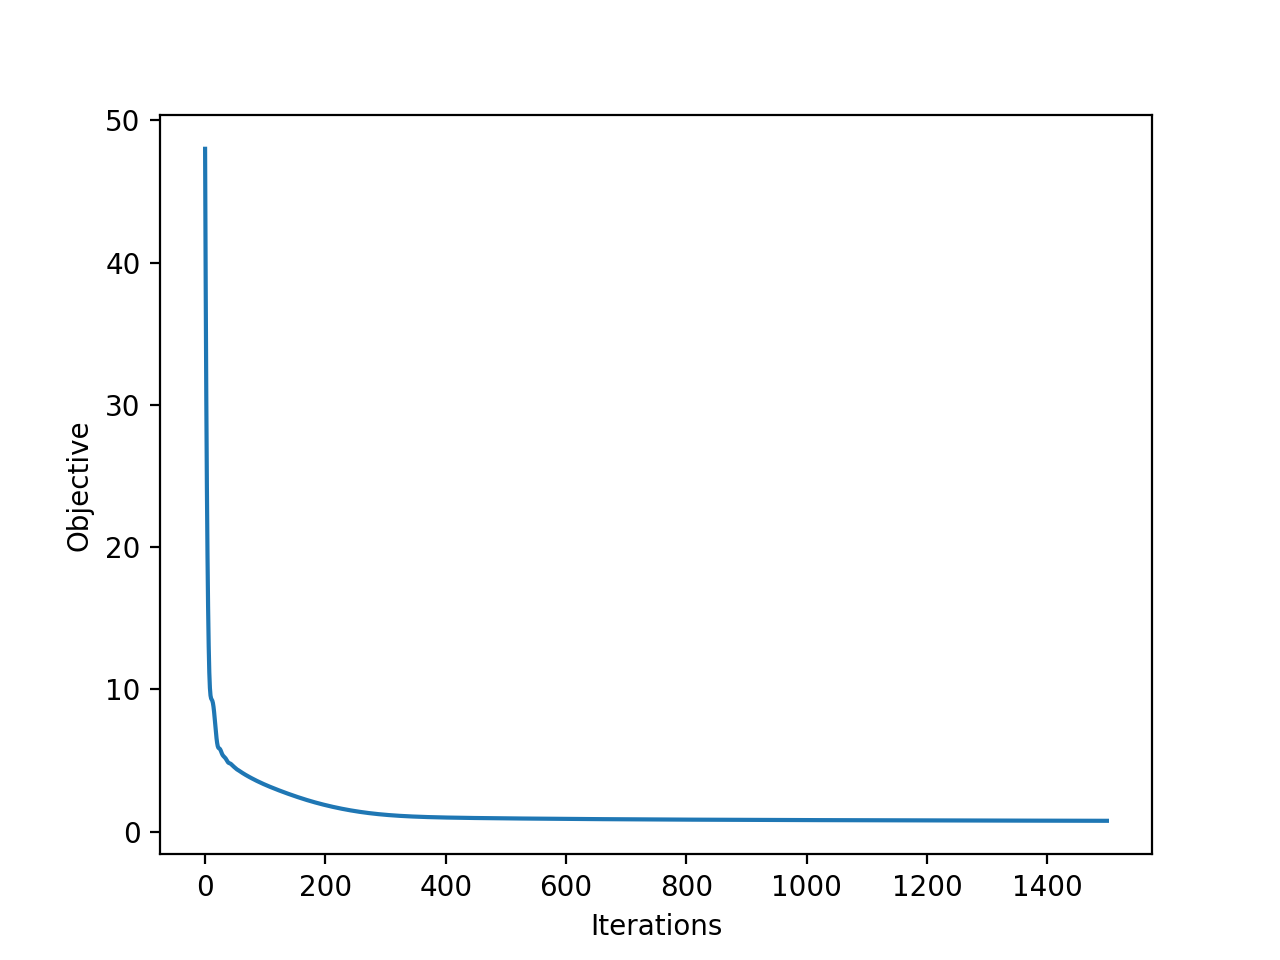

In [135]:
N_train = X_train.shape[0]
# ['zu_0', 'sf_0', 'ls_0', 'eta2_0', 'eta1_R_0']
config_dict = {'M': 30, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':1500,
            'MB': 750, 'lr': 0.01, 'fixed_hyp': [],
            'init_type':True}

model, df, costs = aep_DGP_reg(X_train, y_train, X_test, y_test, 
				conf_dict= config_dict,
				return_cost=True)
fig0 = DGP_figures(model,conf_dict=config_dict).plot_cost(costs)

config_dict2 = {'M': 30, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':1000,
            'MB': 750, 'lr': 0.01, 'fixed_hyp': [],
            'init_type':'greedy'}
model, df = cont_optimization(model, X_test, y_test, conf_dict=config_dict2,
                              new_max_it=1000, return_cost=False)

main_folder = 'scores/'
save_df(main_folder, df, name=config_dict['init_type']+'-5')

### Fitting plots

<IPython.core.display.Javascript object>


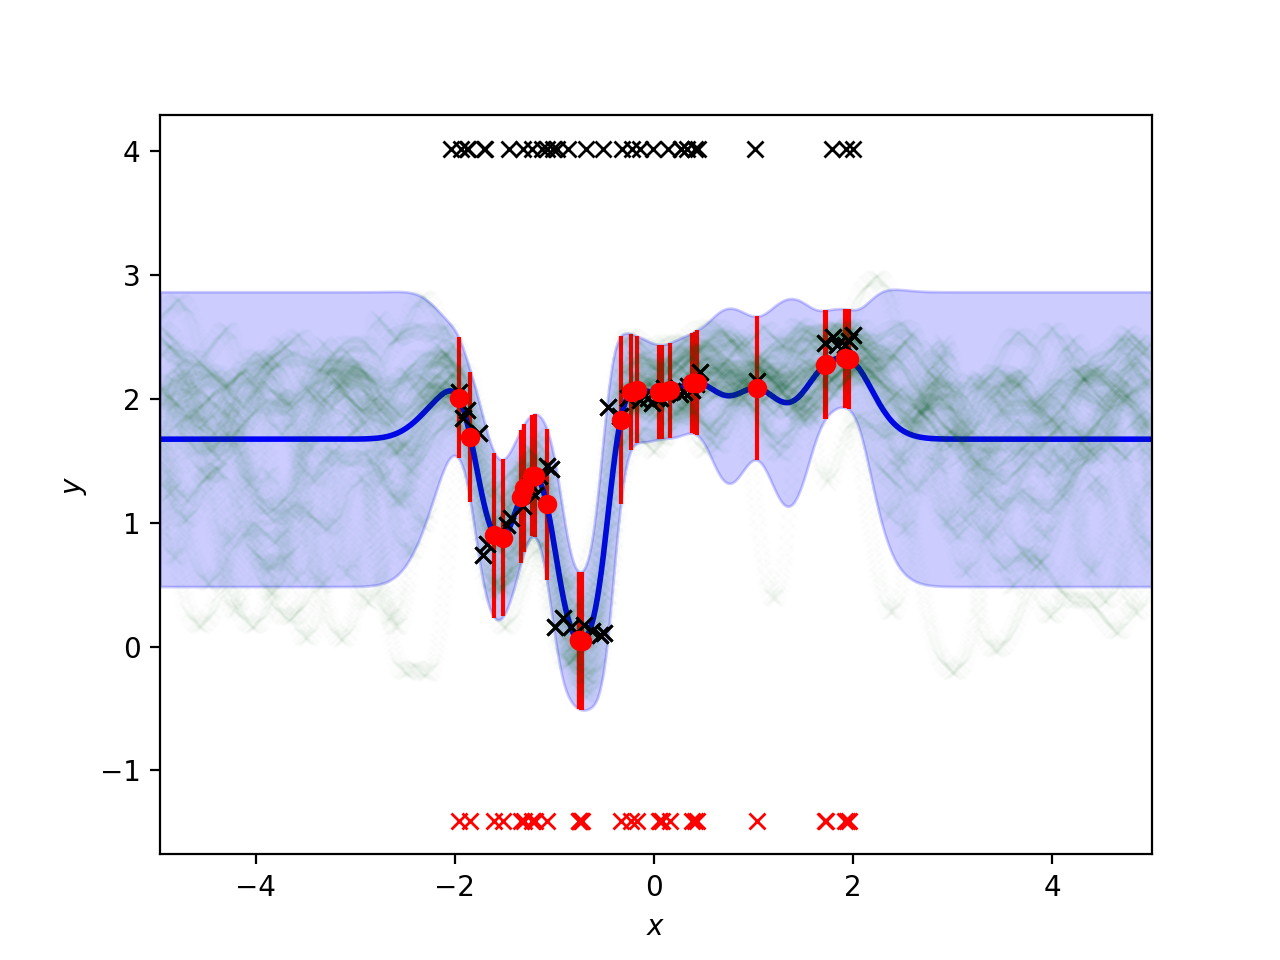

Default initialisation


In [138]:
fig1 = DGP_figures(model, config_dict).plot() 

no_samples = 20
x_min, x_max = np.min(model.x_train)-3, np.max(model.x_train)+3
xx = np.linspace(x_min, x_max, 1000)[:, None]
f_samples = model.sample_f(xx, no_samples)
plt.plot(model.x_train, model.y_train, 'kx', mew=1,alpha=1)
for i in range(no_samples):
    plt.plot(xx, f_samples[:, :, i], 'gx', alpha=0.01)
plt.xlim(x_min, x_max)
plt.plot(model.x_train, model.y_train, 'kx', mew=1,alpha=1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

0.209319278151
0.11462097947
0.23540809307


<IPython.core.display.Javascript object>


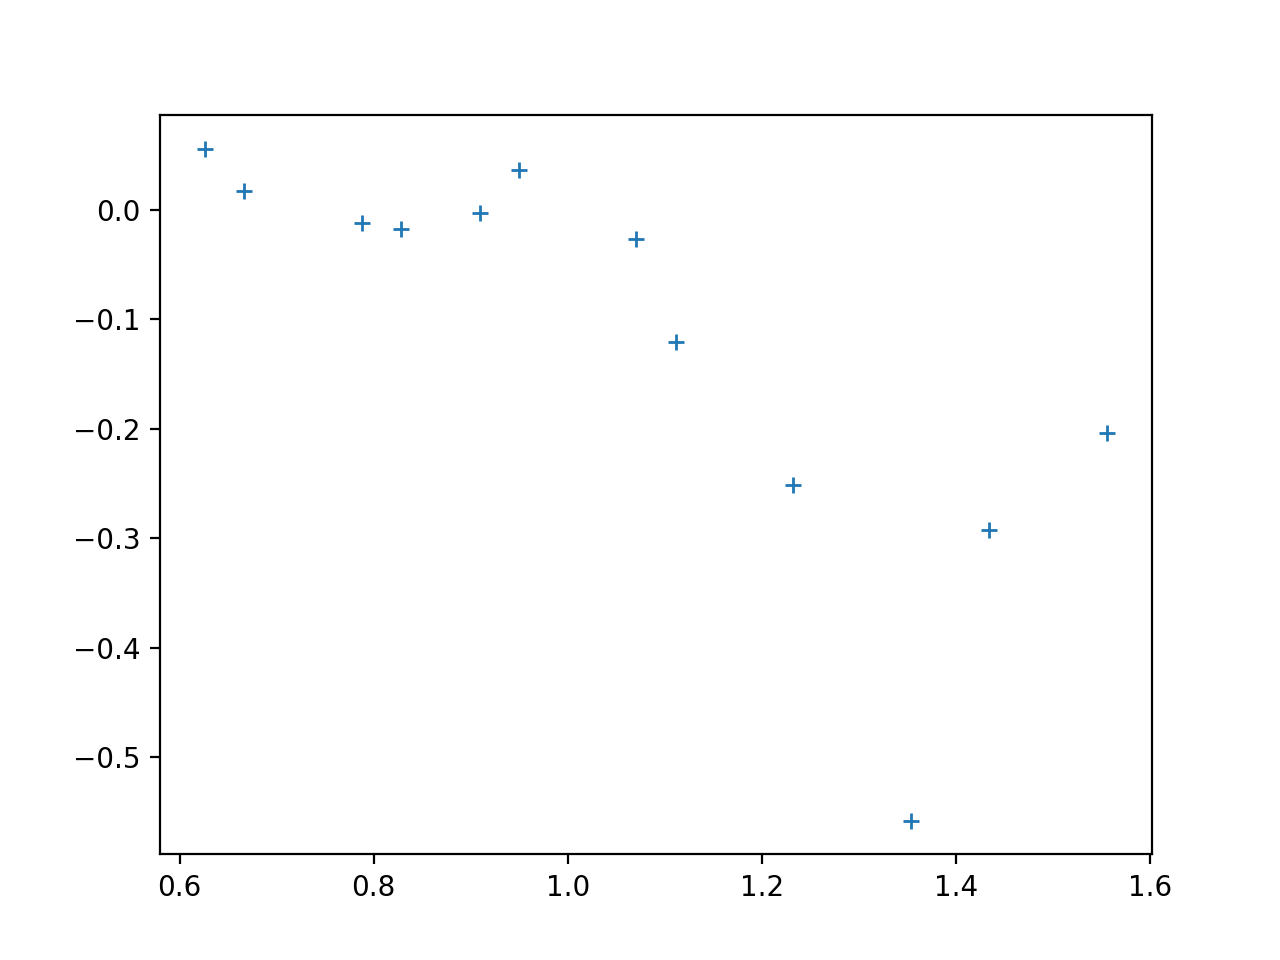

<IPython.core.display.Javascript object>


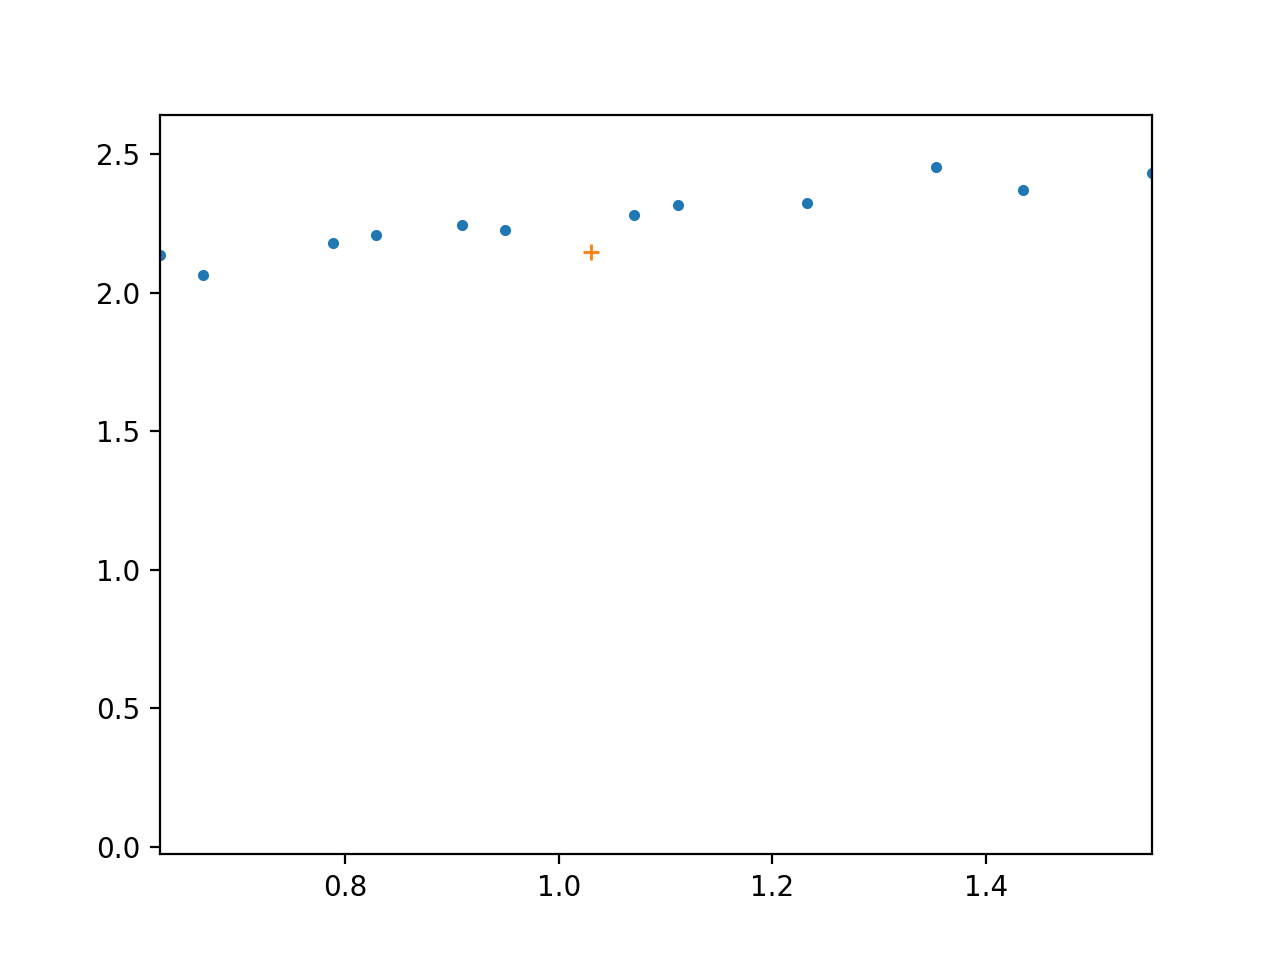

In [137]:
print metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1]).nll()
score, ho_liks = metrics.ho_nll_samples(model, X_test, y_test, N_samples=1000)
print score
print metrics.nll_MLE_samples(model, X_test, y_test, N_samples=1000)
plt.figure()
plt.plot(X_test, ho_liks, '+')
plt.show()
plt.figure()
plt.plot(X_test, y_test, '.')
plt.plot(X_train, y_train, '+')
plt.xlim([np.min(X_test),np.max(X_test)] )
plt.show()

### Hidden Layer

Default initialisation


<IPython.core.display.Javascript object>


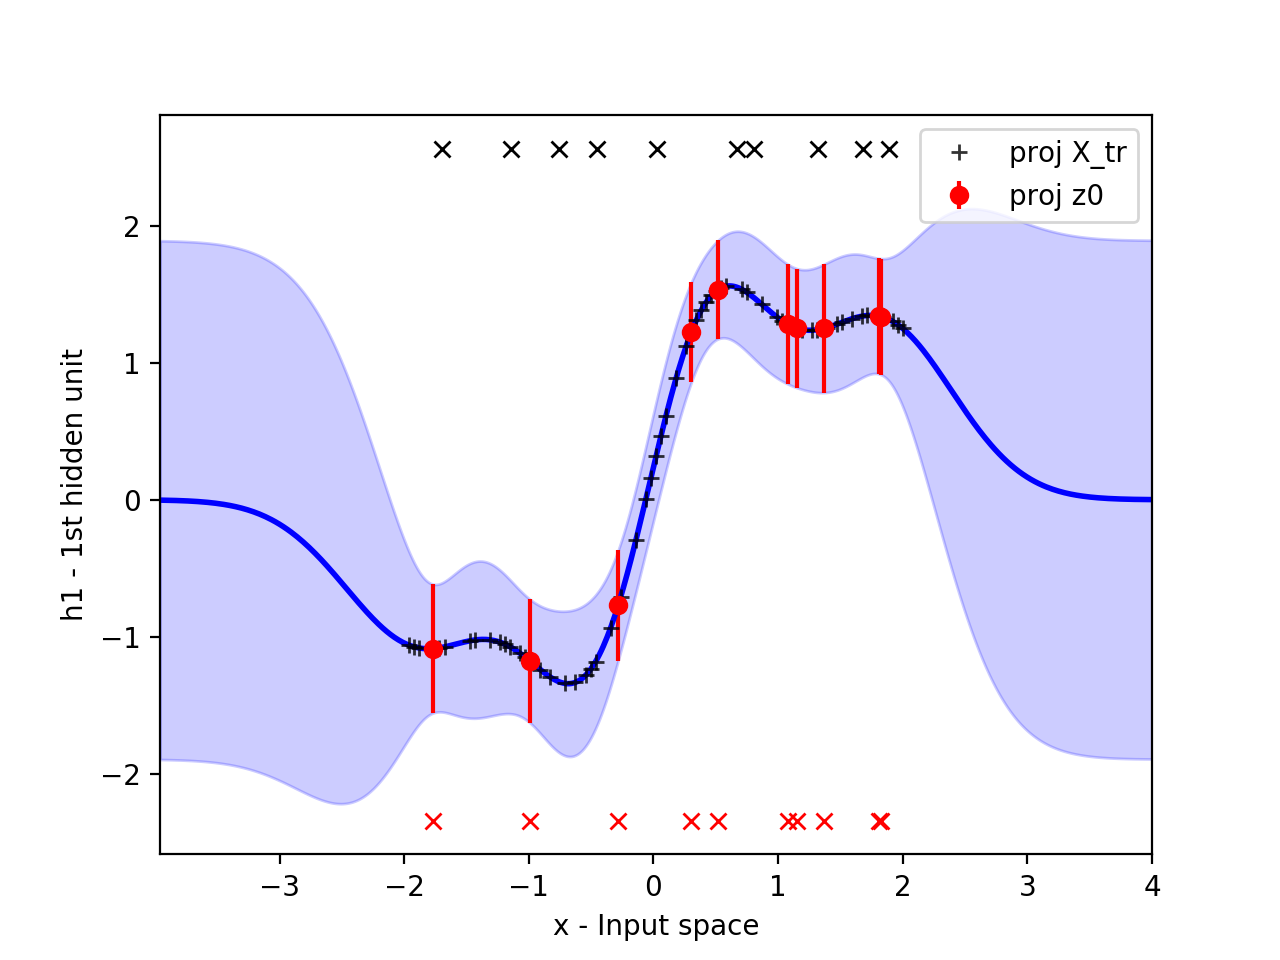

<IPython.core.display.Javascript object>


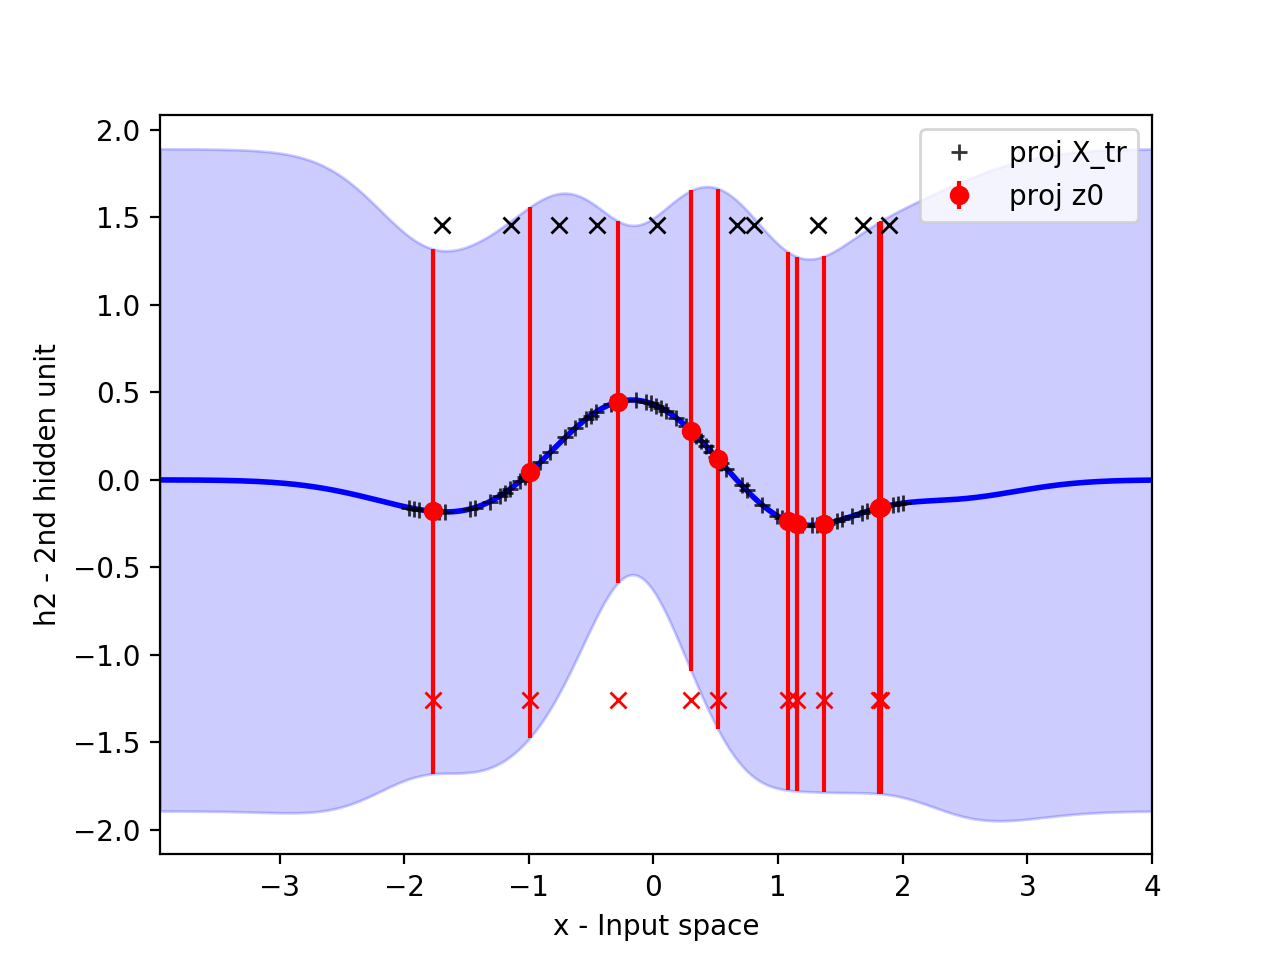

In [59]:
fig3 = DGP_figures(model, conf_dict=config_dict).plot_in_h()

Default initialisation


<IPython.core.display.Javascript object>


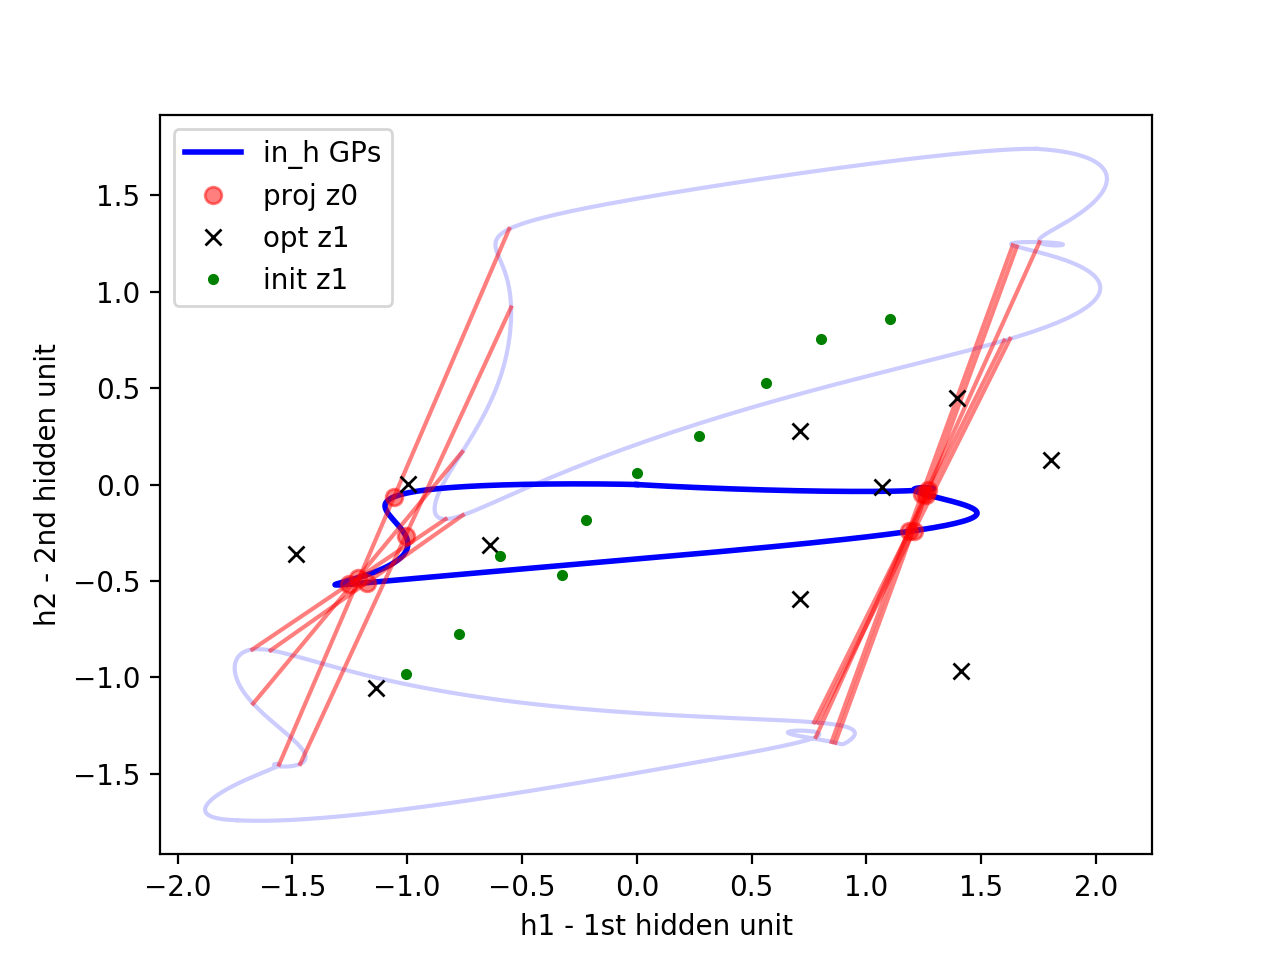

In [14]:
fig4 = DGP_figures(model, conf_dict=config_dict).plot_hidden()

Default initialisation


<IPython.core.display.Javascript object>


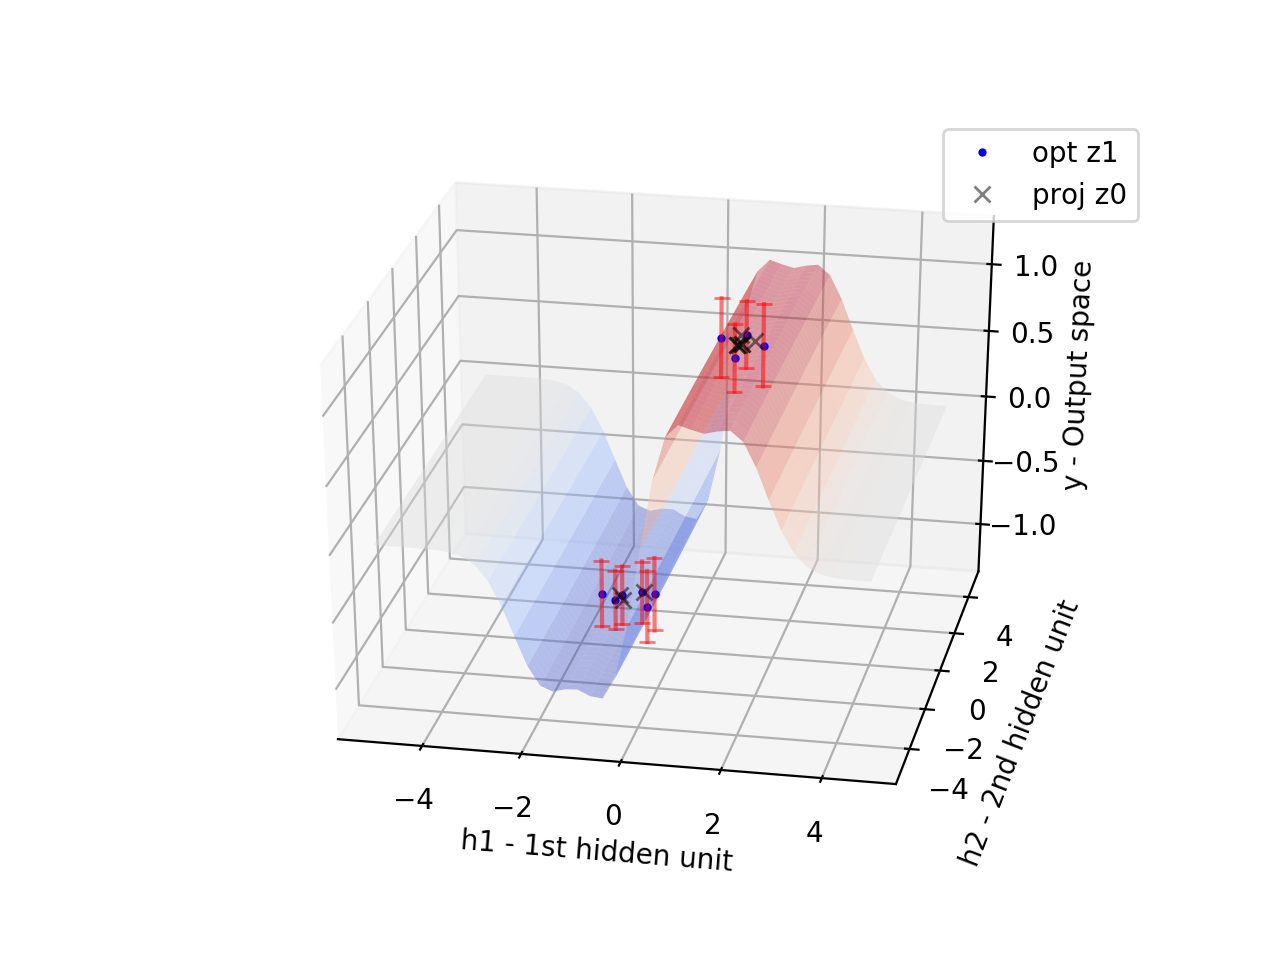

In [60]:
fig5 = DGP_figures(model, conf_dict=config_dict).plot_h_out()

### Initialisations

SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


<IPython.core.display.Javascript object>


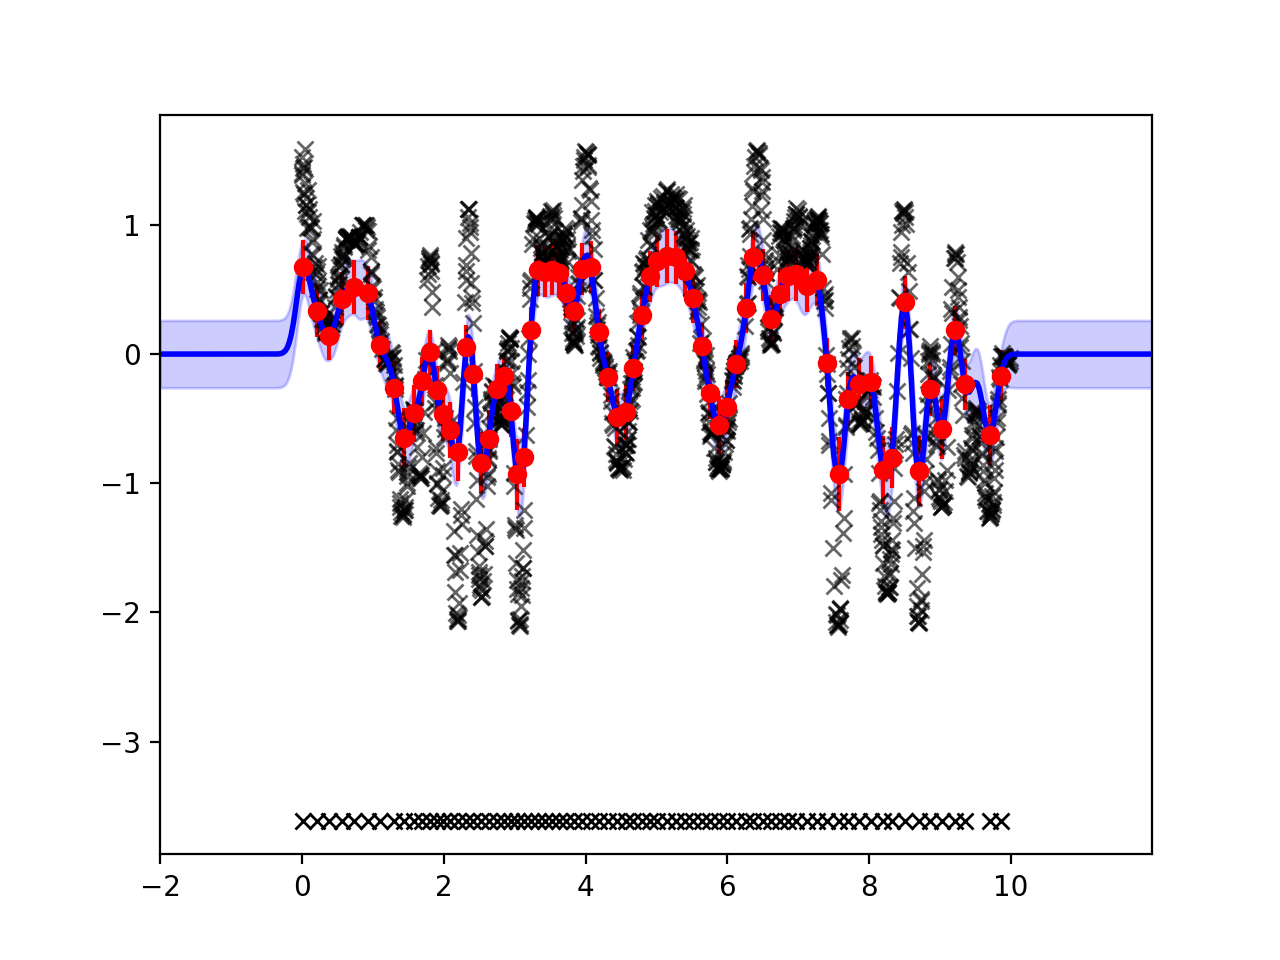

In [21]:
fig6 = DGP_figures(model, conf_dict=config_dict).plot_init()

SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


<IPython.core.display.Javascript object>


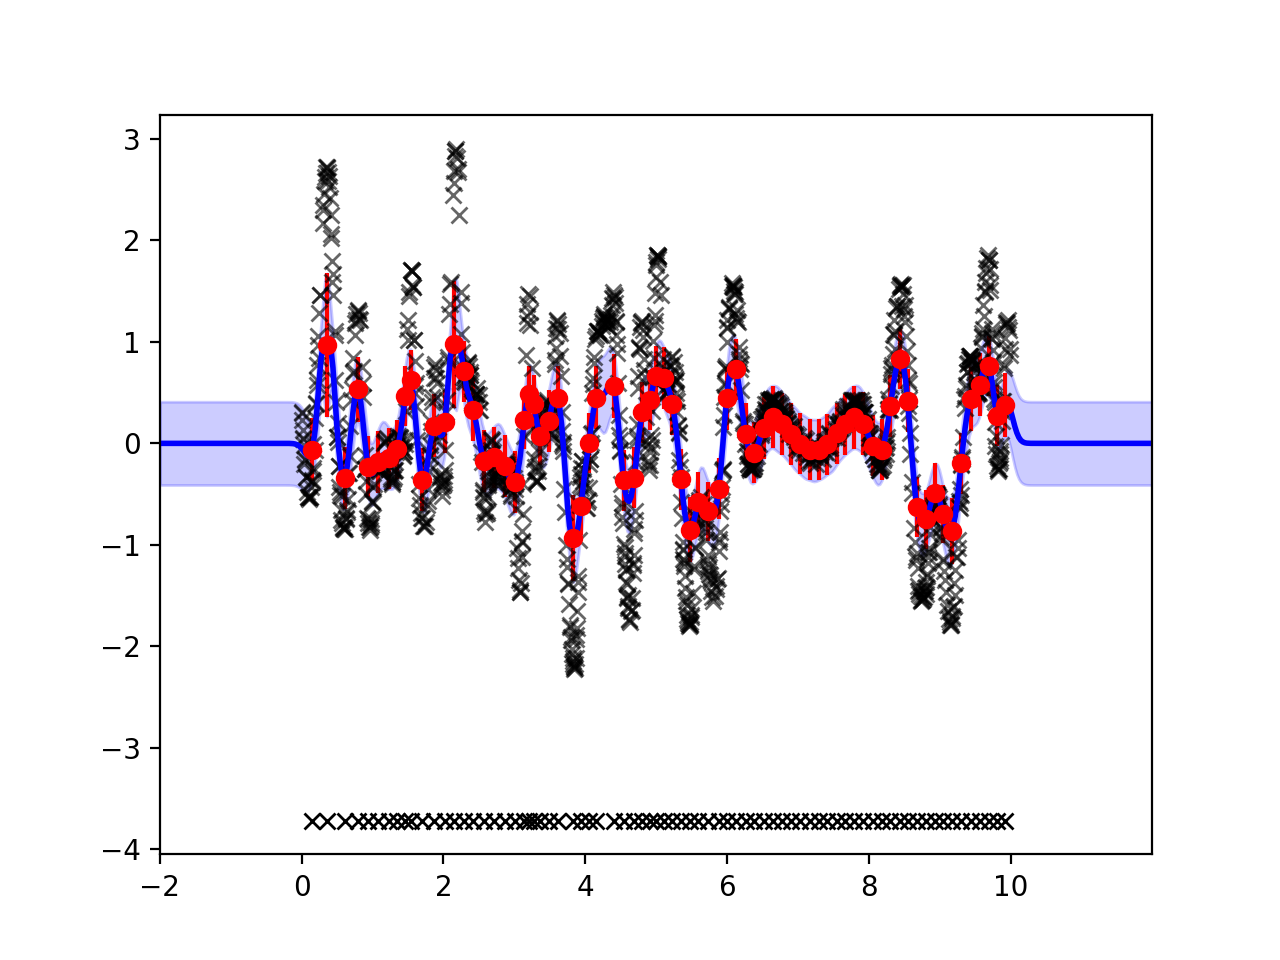

In [94]:
fig6 = DGP_figures(model, conf_dict=config_dict).plot_init()

# Baseline models

In [15]:
model_sgp = GPy.models.SparseGPRegression(X_train,y_train, kernel=GPy.kern.RBF(input_dim=1),num_inducing=50)
param = model_sgp.optimize('bfgs',messages=False)

In [16]:
zu = model_sgp.Z.values
sf = model_sgp.kern.variance.values
ls = model_sgp.kern.lengthscale.values
sn = model_sgp.likelihood.variance.values

In [17]:
def compute_kernel(lls, lsf, x, z):

    ls = np.exp(lls)
    sf = np.exp(lsf)

    if x.ndim == 1:
        x= x[ None, : ]

    if z.ndim == 1:
        z= z[ None, : ]

    r2 = cdist(x, z, 'seuclidean', V = ls)**2.0  
    k = sf * np.exp(-0.5*r2)
    return k
from scipy.spatial.distance import cdist
JITTER = 1e-5
M = 50
Dout = 1

Kuu = compute_kernel(2 * np.log(ls), 2 * np.log(sf), zu, zu)
# Kuu += np.diag(JITTER * np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)

In [18]:
print model_sgp.kern.K(zu)- Kuu

[[  1.00056757e-001   2.09137325e-251   2.58373358e-230 ...,
    3.25734980e-003   6.12440952e-055   2.22580786e-124]
 [  2.09137325e-251   1.00056757e-001   3.42721219e-002 ...,
    1.95506991e-291   4.35820532e-074   4.58659559e-024]
 [  2.58373358e-230   3.42721219e-002   1.00056757e-001 ...,
    1.11381667e-268   6.01399075e-063   4.40795604e-018]
 ..., 
 [  3.25734980e-003   1.95506991e-291   1.11381667e-268 ...,
    1.00056757e-001   3.21079592e-074   7.02528480e-153]
 [  6.12440952e-055   4.35820532e-074   6.01399075e-063 ...,
    3.21079592e-074   1.00056757e-001   5.13846560e-016]
 [  2.22580786e-124   4.58659559e-024   4.40795604e-018 ...,
    7.02528480e-153   5.13846560e-016   1.00056757e-001]]


In [19]:
Kuu = compute_kernel(2 * ls, 2 * sf, zu, zu)
Kuu += np.diag(JITTER * np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)

eta1_R = np.zeros((Dout, M * (M + 1) / 2))
eta2 = np.zeros((Dout, M))
for d in range(Dout):
    mu = np.linspace(-1, 1, M).reshape((M, 1))
    # mu += 0.01 * np.random.randn(M, 1)
    alpha = 0.5 * np.random.rand(M)
    # alpha = 0.1 * np.random.rand(M) # worse init obj = 44.2
    alpha = sn1 * np.random.rand(M)
    Su = np.diag(alpha)
    
    Suinv = np.diag(1 / alpha)
    theta2 = np.dot(Suinv, mu)
    # theta2 = np.dot(Suinv + Kuuinv, mu)
    theta1 = Suinv
    

    R = np.linalg.cholesky(theta1).T
    triu_ind = np.triu_indices(M)
    diag_ind = np.diag_indices(M)
    R[diag_ind] = np.log(R[diag_ind])
    eta1_d = R[triu_ind].reshape((M * (M + 1) / 2,))
    eta2_d = theta2.reshape((M,))
    eta1_R[d, :] = eta1_d
    eta2[d, :] = eta2_d

NameError: name 'sn1' is not defined

In [93]:
mu, Su = model_sgp.predict(zu, full_cov=True)
xx = np.linspace(0,10, 500).reshape(-1,1)
m, S = model_sgp.predict(xx)
Kuu = model_sgp.kern.K(zu)
Kuu += np.diag(1e-2* np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)
Suinv = np.linalg.inv(Su - np.diag(1e-1* np.ones((M, )))) 
theta1 = Suinv - Kuuinv + np.diag(1e-3* np.ones((M, )))
print np.min(np.linalg.eigvals(theta1))
np.linalg.cholesky(theta1).T

2.53898512968


array([[  7.44404435e+00,  -5.10264431e-13,  -4.33130118e-09, ...,
          3.74356367e-02,   1.17746155e-08,  -6.63065221e-12],
       [  0.00000000e+00,   7.00698153e+00,   4.72401406e-01, ...,
         -4.21039471e-10,  -7.27691052e-05,  -9.40852192e-03],
       [  0.00000000e+00,   0.00000000e+00,   7.11402422e+00, ...,
          5.25042220e-11,   4.90605441e-06,   1.04484510e-03],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          7.35007026e+00,  -2.39515823e-05,  -2.18202746e-07],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   7.46165582e+00,  -1.76264906e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   7.14911639e+00]])

eta1_R

In [33]:
eta1_R.shape

(1, 1275)

In [34]:
model_dgp = aep.SDGPR(X_train, y_train, 50, hidden_sizes=[2], lik='Gaussian')
params0 = model_dgp.optimise(method='adam', maxiter=1)

Default initialisation
iter 0 	 obj 41.159


In [35]:
for i in params0.keys():
    print i, params0[i].shape, params0[i]

zu_1 (50, 2) [[-1.001      -0.999     ]
 [-0.96018367 -0.96018367]
 [-0.91736735 -0.91936735]
 [-0.87655102 -0.87855102]
 [-0.83573469 -0.83773469]
 [-0.79491837 -0.79691837]
 [-0.75410204 -0.75610204]
 [-0.71328571 -0.71528571]
 [-0.67246939 -0.67446939]
 [-0.63165306 -0.63365306]
 [-0.59083674 -0.59283673]
 [-0.55002041 -0.55002041]
 [-0.51120408 -0.50920408]
 [-0.47038776 -0.46838776]
 [-0.42957143 -0.42757143]
 [-0.3887551  -0.3867551 ]
 [-0.34793878 -0.34593878]
 [-0.30712245 -0.30512245]
 [-0.26430612 -0.26430612]
 [-0.2234898  -0.2234898 ]
 [-0.18267347 -0.18467347]
 [-0.14185714 -0.14385714]
 [-0.10104082 -0.10304082]
 [-0.06022449 -0.06222449]
 [-0.01940816 -0.02140816]
 [ 0.02140816  0.01940816]
 [ 0.06222449  0.06022449]
 [ 0.10304082  0.10104082]
 [ 0.14385714  0.14185714]
 [ 0.18467347  0.18267347]
 [ 0.2254898   0.2234898 ]
 [ 0.26630612  0.26430612]
 [ 0.30712245  0.30512245]
 [ 0.34793878  0.34593878]
 [ 0.3887551   0.3867551 ]
 [ 0.42957143  0.42757143]
 [ 0.47038776  

In [36]:
params1 = model_dgp.optimise(method='adam', maxiter=100, reinit_hypers=False)

iter 0 	 obj 39.928
iter 50 	 obj 7.400


In [37]:
for i in params1.keys():
    print i, params1[i].shape

zu_1 (50, 2)
zu_0 (50, 1)
sf_0 (1,)
sf_1 (1,)
sn ()
ls_0 (1,)
ls_1 (2,)
eta2_1 (1, 50)
eta2_0 (2, 50)
eta1_R_1 (1, 1275)
eta1_R_0 (2, 1275)


In [80]:
zu.shape

(50, 1)

In [86]:
sn.shape

(1,)